## imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import learning_curve
from joblib import dump, load

## preprocess, train and evaluate functions for base model


In [2]:
# Load and preprocess the data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Dropping rows where 'Metric' column has NaN values
    df = df.dropna(subset=['Metric'])

    # Convert 'Metric' to binary class
    df['Quality'] = df['Metric'].apply(lambda x: 1 if x >= 0.51 else 0)

    # Selecting relevant features
    X = df[['Sentence Count', 'Word Count', 'Similarity Score']]
    y = df['Quality']

    # Splitting the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalizing the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    dump(scaler, 'scaler.joblib') # for adding new data later

    return X_train, X_val, y_train, y_val

# Train the model and evaluate it using random forest
def train_and_evaluate_rf(X_train, X_val, y_train, y_val):
    # Training the Random Forest Classifier
    rf_model = RandomForestClassifier(random_state=42, warm_start=True) # warm_start for adding data later
    rf_model.fit(X_train, y_train)

    # Making predictions on the validation set
    y_pred = rf_model.predict(X_val)
    y_pred_proba = rf_model.predict_proba(X_val)[:, 1]

    # Calculating performance metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Outputting the metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plotting ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Plotting Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    dump(rf_model, 'rf_model.joblib')

    return rf_model

## training data path

In [8]:
file_path = 'data.csv'

## train base model

Accuracy: 0.9883268482490273
Precision: 0.9831932773109243
Recall: 0.9915254237288136
F1 Score: 0.9873417721518987


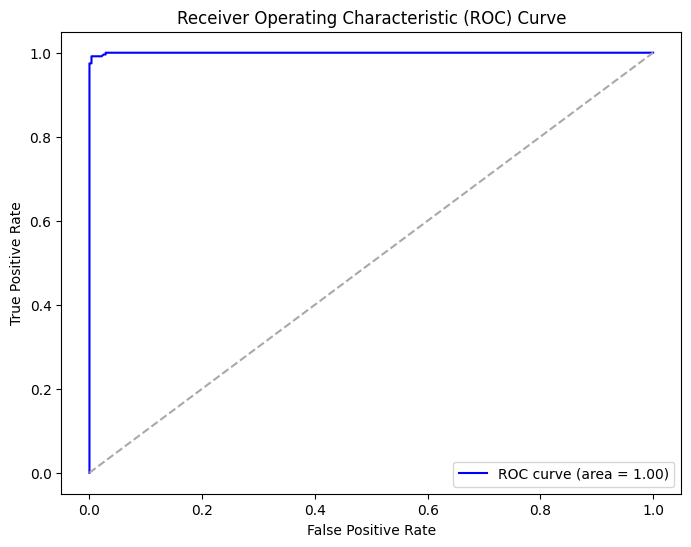

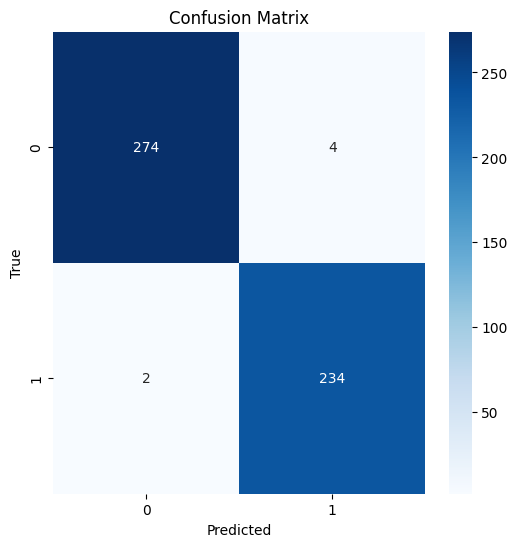

RandomForestClassifier(random_state=42, warm_start=True)

In [9]:
# For Random Forest
X_train, X_val, y_train, y_val = preprocess_data(file_path)
train_and_evaluate_rf(X_train, X_val, y_train, y_val)

## inference with base model

In [10]:
def preprocess_new_data(file_path, scaler):
    # Load new data
    df_new = pd.read_csv(file_path)

    # Dropping rows where 'Metric' column has NaN values
    df_new = df_new.dropna(subset=['Metric'])

    # Convert 'Metric' to binary class
    df_new['Quality'] = df_new['Metric'].apply(lambda x: 1 if x >= 0.51 else 0)

    # Selecting relevant features
    X_new = df_new[['Sentence Count', 'Word Count', 'Similarity Score']]
    y_new = df_new['Quality']

    # Normalizing the features using the scaler from the original data
    X_new = scaler.transform(X_new)

    return X_new, y_new

def process_data_and_save_results(input_csv_filepath, model_filepath, scaler_filepath, output_csv_filepath):
    # Load the RandomForest model and the scaler
    rf_model = load(model_filepath)
    scaler = load(scaler_filepath)

    # Preprocess the new data
    X_new_scaled, df = preprocess_new_data(input_csv_filepath, scaler)

    # Make predictions with the scaled features
    predictions = rf_model.predict(X_new_scaled)

    # Add the predictions as a new column
    df['Predictions'] = predictions

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_csv_filepath, index=False)

In [11]:
process_data_and_save_results('features_test.csv', 'rf_model.joblib', 'scaler.joblib', 'inference_out.csv')

## preprocess, update functions for new data

In [12]:
def preprocess_new_data(file_path, scaler):
    # Load new data
    df_new = pd.read_csv(file_path)

    # Dropping rows where 'Metric' column has NaN values
    df_new = df_new.dropna(subset=['Metric'])

    # Convert 'Metric' to binary class
    df_new['Quality'] = df_new['Metric'].apply(lambda x: 1 if x >= 0.51 else 0)

    # Selecting relevant features
    X_new = df_new[['Sentence Count', 'Word Count', 'Similarity Score']]
    y_new = df_new['Quality']

    # Normalizing the features using the scaler from the original data
    X_new = scaler.transform(X_new)

    return X_new, y_new

def update_model_with_new_data(model_path, new_data_path, scalar):
    # Load the existing model
    existing_model = load(model_path)
    existing_model.n_estimators += 1

    # Load and preprocess new data
    new_X, new_y = preprocess_new_data(new_data_path, scalar)

    # Update the model with new data
    existing_model.fit(new_X, new_y)

    # Save the updated model
    dump(existing_model, 'rf_model_updated.joblib')
    return existing_model

## update model with new data

In [15]:
scaler = load('scaler.joblib')
update_model_with_new_data("./rf_model.joblib", "./test.csv", scaler)

RandomForestClassifier(n_estimators=101, random_state=42, warm_start=True)

## tune precision and recall

In [16]:
def tune_classifier_for_precision_recall(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        # Add more parameters if needed
    }

    rf = RandomForestClassifier(random_state=42)

    scoring = {'f1': make_scorer(f1_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score)}

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring, cv=5, refit='f1', return_train_score=True)
    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_
    for i in range(len(results["params"])):
        print(f"Params: {results['params'][i]}")
        print(f"  Mean Precision: {results['mean_test_precision'][i]}")
        print(f"  Mean Recall: {results['mean_test_recall'][i]}")
        print(f"  Mean F1 Score: {results['mean_test_f1'][i]}")
        print("------")

    # Printing the best parameters and the best F1 score
    print(f"Best parameters for highest F1 score: {grid_search.best_params_}")
    print(f"Highest F1 score: {grid_search.best_score_}")

    return grid_search.best_estimator_

In [17]:
best_rf_model = tune_classifier_for_precision_recall(X_train, y_train)

Params: {'max_depth': 10, 'n_estimators': 100}
  Mean Precision: 0.9829759612625845
  Mean Recall: 0.9838709677419356
  Mean F1 Score: 0.9833564978539282
------
Params: {'max_depth': 10, 'n_estimators': 200}
  Mean Precision: 0.983989100364812
  Mean Recall: 0.9827956989247312
  Mean F1 Score: 0.9833245495217694
------
Params: {'max_depth': 10, 'n_estimators': 300}
  Mean Precision: 0.9840450301730851
  Mean Recall: 0.9838709677419356
  Mean F1 Score: 0.9838748804523174
------
Params: {'max_depth': 20, 'n_estimators': 100}
  Mean Precision: 0.9808264442846211
  Mean Recall: 0.9827956989247312
  Mean F1 Score: 0.9817509695030017
------
Params: {'max_depth': 20, 'n_estimators': 200}
  Mean Precision: 0.983989100364812
  Mean Recall: 0.9827956989247312
  Mean F1 Score: 0.9833245495217694
------
Params: {'max_depth': 20, 'n_estimators': 300}
  Mean Precision: 0.9829253317488611
  Mean Recall: 0.9827956989247312
  Mean F1 Score: 0.9827912392505018
------
Params: {'max_depth': 30, 'n_estimat